In [1]:
# Install dependencies.
!git clone https://github.com/TimothyAlexisVass/udi
!pip install -qq --upgrade transformers accelerate diffusers

Cloning into 'udi'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 150 (delta 62), reused 129 (delta 41), pack-reused 0
Receiving objects: 100% (150/150), 23.81 KiB | 5.95 MiB/s, done.
Resolving deltas: 100% (62/62), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.5 MB/s eta 0:00:00


In [ ]:
!mv udi/worker/bilateral_filter.py /content

In [3]:
# Set the details for your model here:
import torch

from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline, AutoencoderKL, KDPM2AncestralDiscreteScheduler

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)

base2 = StableDiffusionXLImg2ImgPipeline(**base.components)

_ = base.to("cuda")
_ = base2.to("cuda")

tokenizer = base.tokenizer            # cpu
tokenizer_2 = base.tokenizer_2        # cpu
scheduler = base.scheduler            # cpu
text_encoder = base.text_encoder      # cuda
text_encoder_2 = base.text_encoder_2  # cuda
unet = base.unet                      # cuda

torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [49]:
print(unet.parameters().__next__().device)
print(scheduler.init_noise_sigma)

cuda:0
tensor(11.0736, device='cuda:0')


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

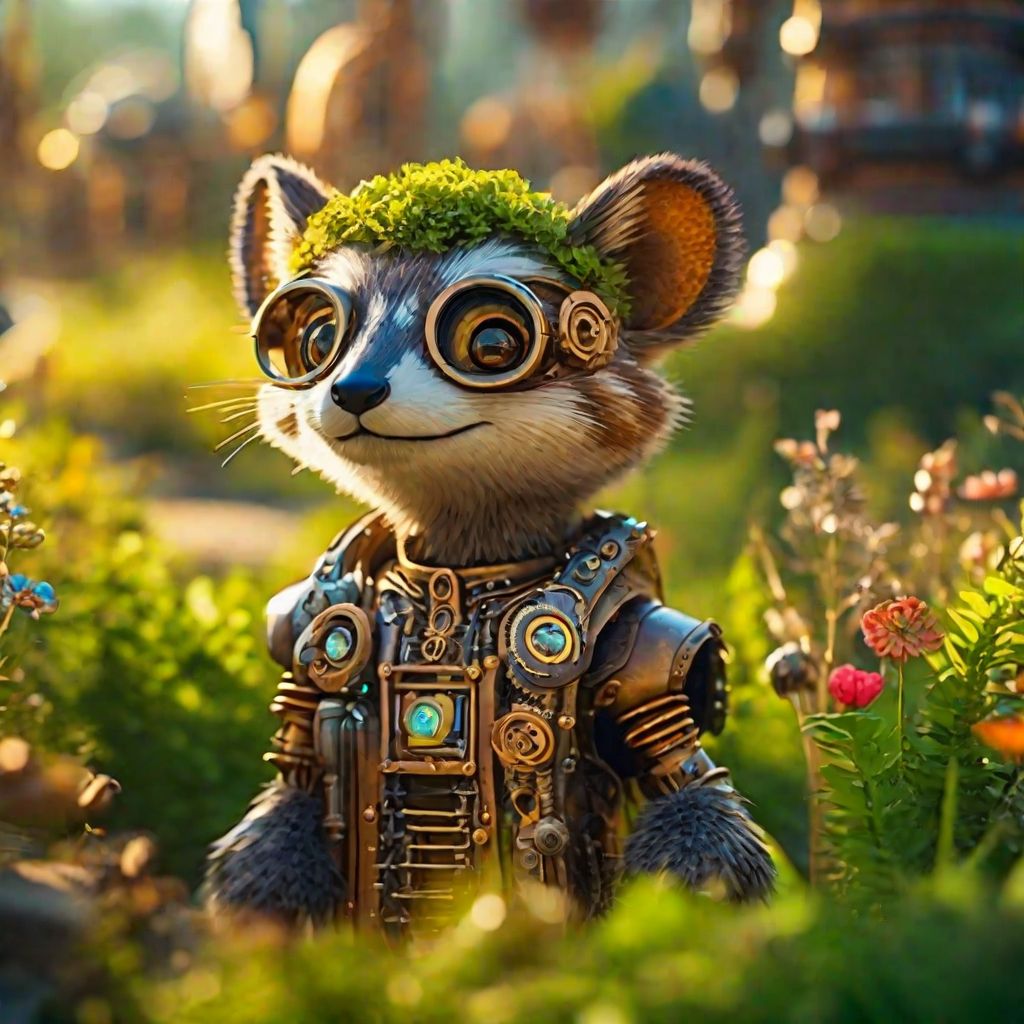

18.882877588272095


In [59]:
# @title Default title text
import os
import zipfile
import random
import torch
# from bilateral_filter import adaptive_bilateral_filter
prompt = f"Steampunk photo of antropomorphic (suricata), pixar, cute, in gray mecha armor looking happy, daylight lush nature park background. Intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"
negative_prompt = "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
num_inference_steps = 20

step_fraction = 1/num_inference_steps

parameters = {
    "prompt": prompt,
    "negative_prompt": negative_prompt,
    "num_inference_steps": num_inference_steps,
    "output_type": "latent",
    "num_images_per_prompt": 1,
    "guidance_scale": 8,
    "denoising_end": step_fraction,
    "generator": torch.manual_seed(2222)
}

import time

# Record the start time
start_time = time.time()

# latents = base(**parameters).images

height = 1024
width = 1024

latents = torch.randn(parameters["num_images_per_prompt"], unet.config.in_channels, height // 8, width // 8).to("cuda") * 11.41

def filter(latents, timestep, sharpness=2):
    t = 1.0 - (timestep / 999.0) # You may adjust this based on your needs

    # Perform sharpness operation on the latents
    alpha = 0.001 * sharpness * t
    degraded_latents = adaptive_bilateral_filter(latents)
    sharp_latents = degraded_latents * alpha + latents * (1.0 - alpha)

    return sharp_latents

@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50):
    scaling = 5 + saturation / 16

    samples = vae.decode(latents * scaling).sample
    samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1).cpu()
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).numpy())


for step in range(0, num_inference_steps):
    latents = base2(**parameters, image=latents).images
    # latents = filter(latents, 999-step*50, -10)
    parameters['denoising_start'] = step * step_fraction
    parameters['denoising_end'] = step * step_fraction + step_fraction

images = decode_latents(latents)

for image in images:
  display(image)

print(time.time()-start_time)

In [ ]:
# @title Default title text
import diffusers

def model(pipeline, model_type):
        if hasattr(diffusers, pipeline):
            model_class = getattr(diffusers, pipeline)
            return model_class(**base.components)
        else:
            raise ValueError(f"Pipeline '{pipeline}' does not exist in Diffusers")
@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50):
    scaling = 5 + saturation / 16
    print("scaling", scaling)
    samples = vae.decode(latents * scaling).sample
    samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1).cpu()
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).numpy())

def run_inference(pipeline, model_type, instructions):
    global num_inference_steps
    num_inference_steps = instructions['num_inference_steps'] = instructions.get('num_inference_steps', 20)

    seed = random.randint(1, 2147483647) if instructions.get('seed', 0) == 0 else instructions['seed']
    saturation = instructions.get('saturation', 50)
    brightness = instructions.get('brightness', 50)
    contrast = instructions.get('contrast', 50)

    parameters = {
        key: instructions[key]
        for key in instructions
        if key not in [
            'seed',
            'saturation',
            'brightness',
            'contrast'
        ]
    }

    parameters['generator'] = torch.manual_seed(seed)
    parameters['output_type'] = 'latent'

    pipe = model(pipeline, model_type).to('cuda')

    latents = pipe(**parameters).images

    images = decode_latents(latents, saturation, contrast, brightness)

    for index, image in enumerate(images):
        display(image)

    pipe = None
    torch.cuda.empty_cache()

instructions = {
    "prompt": f"Steampunk photo of antropomorphic (suricata), pixar, cute, in (gray) mecha armor looking happy, daylight lush nature park background. intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k",
    "seed": 2222,
    "negative_prompt": "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands",
    "guidance_scale": 9
}

run_inference("StableDiffusionXLPipeline", "base", instructions)